In [13]:
from pathlib import Path
import typing as t
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from scipy import stats
from dataclasses import dataclass
from sklearn.metrics import r2_score
import warnings
import pandas as pd
import ast

In [15]:
@dataclass
class FitResults:
    """Container for piecewise regression fit results."""
    r1: float
    r2: float
    params_regime1: dict[str, float]
    params_regime2: dict[str, float] 
    params_regime3: dict[str, float]
    loss_value: float
    regime_percentages: dict[int, float]

class HuberLoss:
    """Implements Huber loss function with configurable threshold."""
    
    def __init__(self, tau: float = 1.0):
        """Initialize Huber loss with threshold parameter."""
        self.tau = tau
    
    def __call__(self, residuals: np.ndarray) -> np.ndarray:
        """Compute Huber loss for given residuals."""
        abs_residuals = np.abs(residuals)
        quadratic = abs_residuals <= self.tau
        linear = abs_residuals > self.tau
        
        loss = np.zeros_like(residuals)
        loss[quadratic] = 0.5 * residuals[quadratic]**2
        loss[linear] = self.tau * (abs_residuals[linear] - 0.5 * self.tau)
        
        return loss
    
    def derivative(self, residuals: np.ndarray) -> np.ndarray:
        """Compute derivative of Huber loss for optimization."""
        abs_residuals = np.abs(residuals)
        derivative = np.zeros_like(residuals)
        
        quadratic = abs_residuals <= self.tau
        derivative[quadratic] = residuals[quadratic]
        derivative[~quadratic] = self.tau * np.sign(residuals[~quadratic])
        
        return derivative

class PiecewiseRegressor:
    """Three-regime piecewise regression with Huber loss and continuity constraints."""
    
    def __init__(
        self, 
        tau: float = 1.0,
        lambda_cont: float = 1.0,
        lambda_delta: float = 0.1
    ):
        """Initialize regressor with hyperparameters."""
        self.tau = tau
        self.lambda_cont = lambda_cont
        self.lambda_delta = lambda_delta
        self.huber_loss = HuberLoss(tau)
        self.fit_results: FitResults | None = None
    
    def _assign_regimes(self, log_ranks: np.ndarray, r1: float, r2: float) -> np.ndarray:
        """Assign each data point to its regime (1, 2, or 3)."""
        regimes = np.ones(len(log_ranks), dtype=int)
        regimes[log_ranks >= np.log(r1)] = 2
        regimes[log_ranks >= np.log(r2)] = 3
        return regimes
    
    def _fit_regime_params(
        self, 
        log_ranks: np.ndarray, 
        log_values: np.ndarray, 
        regime_assignments: np.ndarray,
        N: int
    ) -> tuple[dict, dict, dict]:
        """Fit parameters for each regime separately."""
        params = [{}, {}, {}]
        
        for regime in range(1, 4):
            mask = regime_assignments == regime
            if not np.any(mask):
                # Default parameters if no data in regime
                if regime in [1, 2]:
                    params[regime-1] = {'a': 0.0, 'b': 0.0}
                else:
                    params[regime-1] = {'a': 0.0, 'delta': -1.0}
                continue
                
            x_regime = log_ranks[mask]
            y_regime = log_values[mask]
            
            if regime in [1, 2]:
                # Linear fit: a + b * log(r)
                if len(x_regime) >= 2:
                    slope, intercept, _, _, _ = stats.linregress(x_regime, y_regime)
                    params[regime-1] = {'a': intercept, 'b': slope}
                else:
                    # Single point or no variation
                    params[regime-1] = {'a': np.mean(y_regime), 'b': 0.0}
            else:
                # Regime 3: a + delta * log(log(N) - log(r))
                log_N = np.log(N)
                try:
                    # Avoid numerical issues
                    valid_mask = x_regime < (log_N - 1e-10)
                    if np.any(valid_mask):
                        x_transformed = np.log(log_N - x_regime[valid_mask])
                        y_transformed = y_regime[valid_mask]
                        
                        if len(x_transformed) >= 2:
                            slope, intercept, _, _, _ = stats.linregress(x_transformed, y_transformed)
                            params[regime-1] = {'a': intercept, 'delta': slope}
                        else:
                            params[regime-1] = {'a': np.mean(y_transformed), 'delta': -1.0}
                    else:
                        params[regime-1] = {'a': np.mean(y_regime), 'delta': -1.0}
                except (ValueError, RuntimeWarning):
                    params[regime-1] = {'a': np.mean(y_regime), 'delta': -1.0}
        
        return params[0], params[1], params[2]
    
    def _predict_regime(
        self, 
        log_rank: float | np.ndarray, 
        regime: int, 
        params: dict[str, float],
        N: int
    ) -> float | np.ndarray:
        """Predict value for a single point given regime and parameters."""
        if regime in [1, 2]:
            return params.get('a', 0.0) + params.get('b', 0.0) * log_rank
        else:  # regime 3
            log_N = np.log(N)
            # Avoid numerical issues
            safe_log_rank = np.minimum(log_rank, log_N - 1e-10)
            return params.get('a', 0.0) + params.get('delta', -1.0) * np.log(log_N - safe_log_rank)
    
    def _continuity_penalty(
        self, 
        r1: float, 
        r2: float, 
        params1: dict, 
        params2: dict, 
        params3: dict,
        N: int
    ) -> float:
        """Calculate continuity penalty at regime boundaries."""
        log_r1, log_r2 = np.log(r1), np.log(r2)
        
        # Continuity at r1
        y1_at_r1 = self._predict_regime(log_r1, 1, params1, N)
        y2_at_r1 = self._predict_regime(log_r1, 2, params2, N)
        penalty_r1 = (y1_at_r1 - y2_at_r1)**2
        
        # Continuity at r2
        y2_at_r2 = self._predict_regime(log_r2, 2, params2, N)
        y3_at_r2 = self._predict_regime(log_r2, 3, params3, N)
        penalty_r2 = (y2_at_r2 - y3_at_r2)**2
        
        return penalty_r1 + penalty_r2
    
    def _objective_function(
        self, 
        boundaries: np.ndarray, 
        log_ranks: np.ndarray, 
        log_values: np.ndarray,
        N: int
    ) -> float:
        """Main objective function combining Huber loss, continuity, and regularization."""
        r1, r2 = boundaries
        
        # Ensure valid boundaries
        if r1 <= 1 or r2 <= r1 or r2 >= N:
            return 1e10
        
        # Assign regimes
        regime_assignments = self._assign_regimes(log_ranks, r1, r2)
        
        # Check that each regime has at least some points
        unique_regimes = np.unique(regime_assignments)
        if len(unique_regimes) < 3:
            return 1e10
        
        # Fit regime parameters
        try:
            params1, params2, params3 = self._fit_regime_params(
                log_ranks, log_values, regime_assignments, N
            )
            
            # Calculate predictions and residuals
            predictions = np.zeros_like(log_values)
            for i, (log_r, regime) in enumerate(zip(log_ranks, regime_assignments)):
                if regime == 1:
                    predictions[i] = self._predict_regime(log_r, 1, params1, N)
                elif regime == 2:
                    predictions[i] = self._predict_regime(log_r, 2, params2, N)
                else:
                    predictions[i] = self._predict_regime(log_r, 3, params3, N)
            
            residuals = log_values - predictions
            
            # Huber loss
            huber_loss = np.sum(self.huber_loss(residuals))
            
            # Continuity penalty
            continuity_penalty = self._continuity_penalty(r1, r2, params1, params2, params3, N)
            
            # Delta regularization
            delta_reg = params3.get('delta', 0)**2 if params3 else 0
            
            total_loss = (huber_loss + 
                         self.lambda_cont * continuity_penalty + 
                         self.lambda_delta * delta_reg)
            
            return total_loss
            
        except Exception:
            return 1e10
    
    def fit(self, ranks: np.ndarray, delta_loss: np.ndarray) -> FitResults:
        """Fit the piecewise regression model to data."""
        # Transform to log space
        log_ranks = np.log(ranks)
        log_values = np.log(delta_loss)
        N = len(ranks)
        
        # Sort data by rank for proper boundary search
        sort_idx = np.argsort(ranks)
        ranks_sorted = ranks[sort_idx]
        log_ranks_sorted = log_ranks[sort_idx]
        log_values_sorted = log_values[sort_idx]
        
        # Define reasonable bounds for boundary search
        min_rank, max_rank = ranks_sorted[5], ranks_sorted[-5]  # Leave some margin
        
        # Multiple initial guesses for robust optimization
        r1_candidates = np.percentile(ranks_sorted, [10, 20, 30])
        r2_candidates = np.percentile(ranks_sorted, [60, 70, 80])
        
        best_loss = float('inf')
        best_boundaries = None
        
        # Try different initialization points
        for r1_init in r1_candidates:
            for r2_init in r2_candidates:
                if r2_init <= r1_init:
                    continue
                    
                # Bounds ensuring r1 < r2 and reasonable separation
                bounds = [
                    (min_rank, min(r2_init - 1, max_rank * 0.4)),
                    (max(r1_init + 1, min_rank * 2), max_rank)
                ]
                
                # Skip if bounds are invalid
                if bounds[0][0] >= bounds[0][1] or bounds[1][0] >= bounds[1][1]:
                    continue
                
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        
                        result = differential_evolution(
                            self._objective_function,
                            bounds,
                            args=(log_ranks_sorted, log_values_sorted, N),
                            maxiter=50,
                            seed=42,
                            atol=1e-6,
                            workers=1
                        )
                    
                    if result.fun < best_loss:
                        best_loss = result.fun
                        best_boundaries = result.x
                        
                except Exception:
                    continue
        
        if best_boundaries is None:
            # Fallback to simple quantile-based boundaries
            best_boundaries = [
                np.percentile(ranks_sorted, 25),
                np.percentile(ranks_sorted, 75)
            ]
        
        # Extract optimal boundaries
        r1_opt, r2_opt = best_boundaries
        
        # Final parameter fitting with optimal boundaries
        regime_assignments = self._assign_regimes(log_ranks_sorted, r1_opt, r2_opt)
        params1, params2, params3 = self._fit_regime_params(
            log_ranks_sorted, log_values_sorted, regime_assignments, N
        )
        
        # Calculate regime percentages
        regime_counts = np.bincount(regime_assignments, minlength=4)[1:]
        regime_percentages = {
            i+1: count/len(regime_assignments)*100 
            for i, count in enumerate(regime_counts)
        }
        
        # Store results
        self.fit_results = FitResults(
            r1=r1_opt,
            r2=r2_opt,
            params_regime1=params1,
            params_regime2=params2,
            params_regime3=params3,
            loss_value=best_loss,
            regime_percentages=regime_percentages
        )
        
        return self.fit_results
    
    def predict(self, ranks: np.ndarray) -> np.ndarray:
        """Predict values for new rank data using fitted model."""
        if self.fit_results is None:
            raise ValueError("Model must be fitted before prediction")
        
        log_ranks = np.log(ranks)
        N = len(ranks)
        regime_assignments = self._assign_regimes(log_ranks, self.fit_results.r1, self.fit_results.r2)
        
        predictions = np.zeros(len(ranks))
        for i, (log_r, regime) in enumerate(zip(log_ranks, regime_assignments)):
            if regime == 1:
                pred = self._predict_regime(log_r, 1, self.fit_results.params_regime1, N)
            elif regime == 2:
                pred = self._predict_regime(log_r, 2, self.fit_results.params_regime2, N)
            else:
                pred = self._predict_regime(log_r, 3, self.fit_results.params_regime3, N)
            predictions[i] = pred
        
        return np.exp(predictions)
    
    def get_regime_boundaries(self) -> tuple[float, float]:
        """Get the fitted regime boundaries r1 and r2."""
        if self.fit_results is None:
            raise ValueError("Model must be fitted first")
        return self.fit_results.r1, self.fit_results.r2



In [39]:
class PiecewiseRegressionPlotter:
    """Visualization tools for piecewise regression results."""
    
    def __init__(self, figsize: tuple[int, int] = (12, 8)):
        """Initialize plotter with figure configuration."""
        self.figsize = figsize
        self.regime_colors = {'regime1': '#E6E6FA', 'regime2': '#E0FFE0', 'regime3': '#FFE0E0'}
        self.line_colors = {'regime1': 'blue', 'regime2': 'green', 'regime3': 'red'}
    
    def plot_fit_results(
        self, 
        log_ranks: np.ndarray, 
        log_values: np.ndarray, 
        fit_results: FitResults,
        save_path: Path | None = None
    ) -> plt.Figure:
        """Create main piecewise regression visualization matching the example."""
        fig, ax = plt.subplots(figsize=self.figsize)
        
      
        N = len(log_ranks)
        
        # Add regime backgrounds
        self._add_regime_backgrounds(ax, log_ranks, fit_results.r1, fit_results.r2)
        
        # Plot original data points
        ax.scatter(log_ranks, log_values, alpha=0.6, s=30, color='steelblue', zorder=3)
        
        # Add regime labels
        self._add_regime_labels(ax, fit_results.regime_percentages, fit_results.r1, fit_results.r2, log_ranks)
        
        # Styling
        ax.set_xlabel('Log Rank', fontsize=14)
        ax.set_ylabel('Log Value', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        plt.tight_layout()
        
        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig
    
    def plot_residuals(
        self, 
        ranks: np.ndarray, 
        delta_loss: np.ndarray, 
        fit_results: FitResults
    ) -> plt.Figure:
        """Plot residual analysis for model diagnostics."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Calculate residuals
        regressor = PiecewiseRegressor()
        regressor.fit_results = fit_results
        predicted = regressor.predict(ranks)
        residuals = delta_loss - predicted
        
        # Residuals vs fitted
        ax1.scatter(predicted, residuals, alpha=0.6)
        ax1.axhline(0, color='red', linestyle='--')
        ax1.set_xlabel('Fitted Values')
        ax1.set_ylabel('Residuals')
        ax1.set_title('Residuals vs Fitted')
        ax1.grid(True, alpha=0.3)
        
        # Q-Q plot
        stats.probplot(residuals, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_regime_breakdown(self, fit_results: FitResults) -> plt.Figure:
        """Display statistical breakdown of regime assignments."""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        regimes = list(fit_results.regime_percentages.keys())
        percentages = list(fit_results.regime_percentages.values())
        colors = [self.line_colors[f'regime{i}'] for i in regimes]
        
        bars = ax.bar(regimes, percentages, color=colors, alpha=0.7)
        
        # Add percentage labels on bars
        for bar, pct in zip(bars, percentages):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)
        
        ax.set_xlabel('Regime')
        ax.set_ylabel('Percentage of Data Points')
        ax.set_title('Data Distribution Across Regimes')
        ax.set_xticks(regimes)
        ax.set_xticklabels([f'Regime {i}' for i in regimes])
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        return fig
    
    def _add_regime_backgrounds(
        self, 
        ax: plt.Axes, 
        log_ranks: np.ndarray, 
        r1: float, 
        r2: float
    ) -> None:
        """Add colored background regions for each regime."""
        x_min, x_max = log_ranks.min(), log_ranks.max()
        log_r1, log_r2 = np.log(r1), np.log(r2)
        
        # Regime 1 background
        ax.axvspan(x_min, log_r1, alpha=0.2, color='blue', zorder=1)
        
        # Regime 2 background  
        ax.axvspan(log_r1, log_r2, alpha=0.2, color='green', zorder=1)
        
        # Regime 3 background
        ax.axvspan(log_r2, x_max, alpha=0.2, color='red', zorder=1)
    
    def _add_regime_labels(
        self, 
        ax: plt.Axes, 
        regime_percentages: dict[int, float],
        r1: float, 
        r2: float,
        log_ranks: np.ndarray
    ) -> None:
        """Add percentage labels to each regime region."""
        x_min, x_max = log_ranks.min(), log_ranks.max()
        log_r1, log_r2 = np.log(r1), np.log(r2)
        y_min, y_max = ax.get_ylim()
        
        # Calculate label positions
        regime1_center = (x_min + log_r1) / 2
        regime2_center = (log_r1 + log_r2) / 2
        regime3_center = (log_r2 + x_max) / 2
        label_y = y_min + 0.85 * (y_max - y_min)
        
        # Add labels
        colors = ['blue', 'green', 'red']
        centers = [regime1_center, regime2_center, regime3_center]
        
        for i, (center, color) in enumerate(zip(centers, colors)):
            pct = regime_percentages.get(i+1, 0)
            ax.text(center, label_y, f'{pct:.1f}%', 
                   ha='center', va='center', fontsize=16, 
                   color=color, fontweight='bold', zorder=6)
    
    def _assign_regimes_array(self, log_ranks: np.ndarray, r1: float, r2: float) -> np.ndarray:
        """Assign regimes for array of log ranks."""
        regimes = np.ones(len(log_ranks), dtype=int)
        regimes[log_ranks >= np.log(r1)] = 2
        regimes[log_ranks >= np.log(r2)] = 3
        return regimes
    
    def _predict_single(self, log_rank: float, regime: int, params: dict[str, float], N: int) -> float:
        """Predict single value for plotting."""
        if regime in [1, 2]:
            return params.get('a', 0.0) + params.get('b', 0.0) * log_rank
        else:  # regime 3
            log_N = np.log(N)
            safe_log_rank = min(log_rank, log_N - 1e-10)
            return params.get('a', 0.0) + params.get('delta', -1.0) * np.log(log_N - safe_log_rank)

class PiecewiseRegressionPipeline:
    """High-level pipeline for complete piecewise regression analysis."""
    
    def __init__(
        self,
        tau: float = 1.0,
        lambda_cont: float = 1.0, 
        lambda_delta: float = 0.1,
        figsize: tuple[int, int] = (12, 8)
    ):
        """Initialize pipeline with model and plotting configurations."""
        self.regressor = PiecewiseRegressor(tau, lambda_cont, lambda_delta)
        self.plotter = PiecewiseRegressionPlotter(figsize)
    
    def run_analysis(
        self,
        ranks: np.ndarray,
        delta_loss: np.ndarray,
        output_dir: Path | None = None
    ) -> tuple[FitResults, dict[str, plt.Figure]]:
        """Run complete analysis pipeline with fitting and visualization."""
        
        # Fit the model
        print("Fitting piecewise regression model...")
        fit_results = self.regressor.fit(ranks, delta_loss)
        
        # Generate plots
        print("Generating visualizations...")
        plots = {}
        
        # Main fit plot
        plots['fit'] = self.plotter.plot_fit_results(ranks, delta_loss, fit_results)
        
        # Residual analysis
        #plots['residuals'] = self.plotter.plot_residuals(ranks, delta_loss, fit_results)
        
        # Regime breakdown
        #plots['breakdown'] = self.plotter.plot_regime_breakdown(fit_results)
        
        # Save plots if output directory specified
        if output_dir:
            output_dir = Path(output_dir)
            output_dir.mkdir(parents=True, exist_ok=True)
            
            for name, fig in plots.items():
                fig.savefig(output_dir / f'{name}_plot.png', dpi=300, bbox_inches='tight')
        
        # Print summary
        self._print_summary(fit_results)
        
        return fit_results, plots
    
    def cross_validate_hyperparameters(
        self,
        ranks: np.ndarray,
        delta_loss: np.ndarray,
        param_grid: dict[str, list[float]]
    ) -> dict[str, float]:
        """Cross-validation for hyperparameter selection."""
        best_loss = float('inf')
        best_params = {}
        
        # Simple grid search
        for tau in param_grid.get('tau', [self.regressor.tau]):
            for lambda_cont in param_grid.get('lambda_cont', [self.regressor.lambda_cont]):
                for lambda_delta in param_grid.get('lambda_delta', [self.regressor.lambda_delta]):
                    
                    regressor = PiecewiseRegressor(tau, lambda_cont, lambda_delta)
                    try:
                        results = regressor.fit(ranks, delta_loss)
                        if results.loss_value < best_loss:
                            best_loss = results.loss_value
                            best_params = {'tau': tau, 'lambda_cont': lambda_cont, 'lambda_delta': lambda_delta}
                    except Exception:
                        continue
        
        return best_params
    
    def _print_summary(self, fit_results: FitResults) -> None:
        """Print summary of fit results."""
        print(f"\n{'='*50}")
        print("PIECEWISE REGRESSION RESULTS")
        print(f"{'='*50}")
        print(f"Regime boundaries:")
        print(f"  r1 = {fit_results.r1:.2f}")
        print(f"  r2 = {fit_results.r2:.2f}")
        print(f"\nRegime percentages:")
        for regime, pct in fit_results.regime_percentages.items():
            print(f"  Regime {regime}: {pct:.1f}%")
        print(f"\nFinal loss value: {fit_results.loss_value:.4f}")
        print(f"{'='*50}")



In [ ]:
class PiecewiseRegressionPipeline:
    """High-level pipeline for complete piecewise regression analysis."""
    
    def __init__(
        self,
        tau: float = 1.0,
        lambda_cont: float = 1.0, 
        lambda_delta: float = 0.1,
        figsize: tuple[int, int] = (12, 8)
    ):
        """Initialize pipeline with model and plotting configurations."""
        self.regressor = PiecewiseRegressor(tau, lambda_cont, lambda_delta)
        self.plotter = PiecewiseRegressionPlotter(figsize)
    
    def run_analysis(
        self,
        ranks: np.ndarray,
        delta_loss: np.ndarray,
        output_dir: Path | None = None
    ) -> tuple[FitResults, dict[str, plt.Figure]]:
        """Run complete analysis pipeline with fitting and visualization."""
        
        # Fit the model
        print("Fitting piecewise regression model...")
        fit_results = self.regressor.fit(ranks, delta_loss)
        
        # Generate plots
        print("Generating visualizations...")
        plots = {}
        
        # Main fit plot
        plots['fit'] = self.plotter.plot_fit_results(ranks, delta_loss, fit_results)
        
        # Residual analysis
        #plots['residuals'] = self.plotter.plot_residuals(ranks, delta_loss, fit_results)
        
        # Regime breakdown
        #plots['breakdown'] = self.plotter.plot_regime_breakdown(fit_results)
        
        # Save plots if output directory specified
        if output_dir:
            output_dir = Path(output_dir)
            output_dir.mkdir(parents=True, exist_ok=True)
            
            for name, fig in plots.items():
                fig.savefig(output_dir / f'{name}_plot.png', dpi=300, bbox_inches='tight')
        
        # Print summary
        self._print_summary(fit_results)
        
        return fit_results, plots
    
    def cross_validate_hyperparameters(
        self,
        ranks: np.ndarray,
        delta_loss: np.ndarray,
        param_grid: dict[str, list[float]]
    ) -> dict[str, float]:
        """Cross-validation for hyperparameter selection."""
        best_loss = float('inf')
        best_params = {}
        
        # Simple grid search
        for tau in param_grid.get('tau', [self.regressor.tau]):
            for lambda_cont in param_grid.get('lambda_cont', [self.regressor.lambda_cont]):
                for lambda_delta in param_grid.get('lambda_delta', [self.regressor.lambda_delta]):
                    
                    regressor = PiecewiseRegressor(tau, lambda_cont, lambda_delta)
                    try:
                        results = regressor.fit(ranks, delta_loss)
                        if results.loss_value < best_loss:
                            best_loss = results.loss_value
                            best_params = {'tau': tau, 'lambda_cont': lambda_cont, 'lambda_delta': lambda_delta}
                    except Exception:
                        continue
        
        return best_params
    
    def _print_summary(self, fit_results: FitResults) -> None:
        """Print summary of fit results."""
        print(f"\n{'='*50}")
        print("PIECEWISE REGRESSION RESULTS")
        print(f"{'='*50}")
        print(f"Regime boundaries:")
        print(f"  r1 = {fit_results.r1:.2f}")
        print(f"  r2 = {fit_results.r2:.2f}")
        print(f"\nRegime percentages:")
        for regime, pct in fit_results.regime_percentages.items():
            print(f"  Regime {regime}: {pct:.1f}%")
        print(f"\nFinal loss value: {fit_results.loss_value:.4f}")
        print(f"{'='*50}")

In [ ]:
def load_data(values: list[float]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None:
    """Analyze values using Zipf's law and return log-log data with power law fit."""
    arr = np.array(values)
    
    # Handle different data types and structures
    if arr.ndim > 1:
        arr = arr.flatten()
    
    # Remove non-finite values and filter positive values
    arr = arr[np.isfinite(arr)]
    positive_vals = arr[arr > 0]
    
    # Check if we have enough valid data points
    if len(positive_vals) < 10:
        print(f"Warning: Only {len(positive_vals)} positive values found, skipping analysis")
        return None
    
    sorted_vals = np.sort(positive_vals)[::-1]  # Sort in descending order
    ranks = np.arange(1, len(sorted_vals) + 1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    return log_ranks, log_vals

Fitting piecewise regression model...


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_47416/2441495739.py:219: RuntimeWarning: divide by zero encountered in log
  log_ranks = np.log(ranks)
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_47416/2441495739.py:220: RuntimeWarning: invalid value encountered in log
  log_values = np.log(delta_loss)


Generating visualizations...

PIECEWISE REGRESSION RESULTS
Regime boundaries:
  r1 = 6.68
  r2 = 7.78

Regime percentages:
  Regime 1: 25.0%
  Regime 2: 50.0%
  Regime 3: 25.0%

Final loss value: inf


/Users/jliu/anaconda3/envs/genai/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


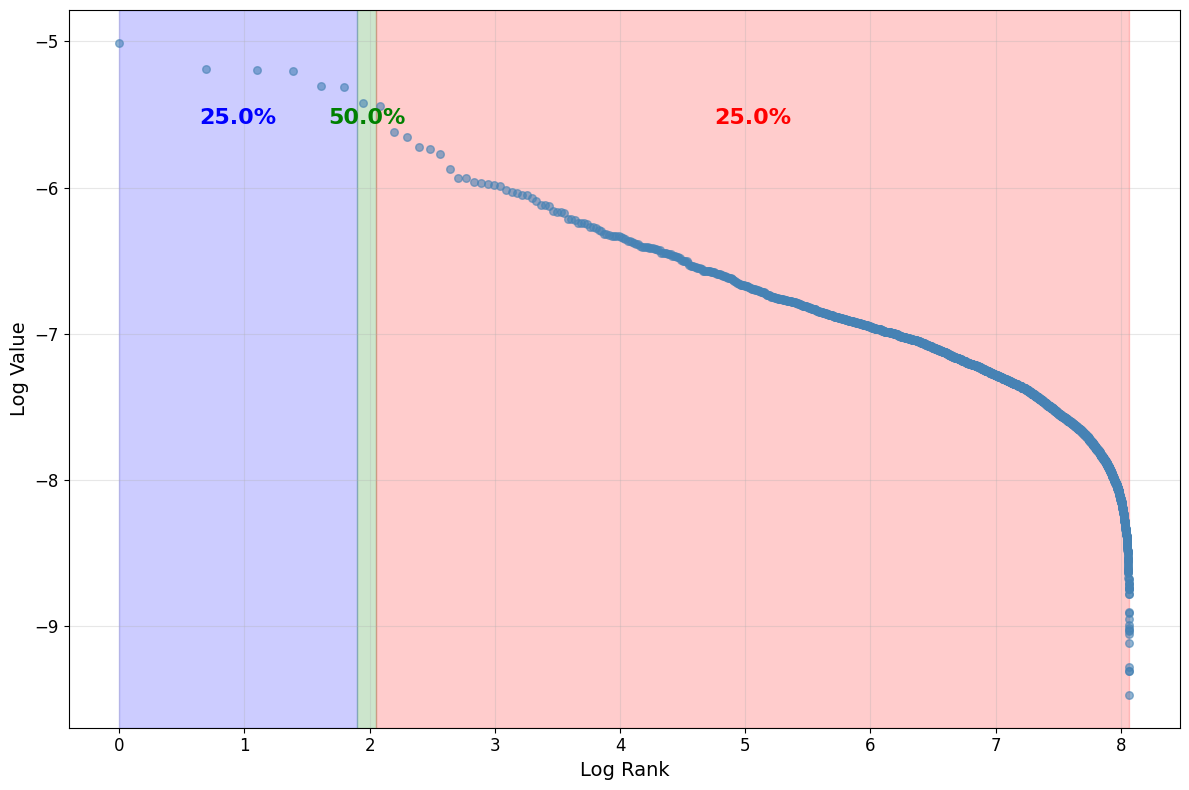

In [40]:
ROOT_dir = Path('/Users/jliu/workspace/RAG')
root_path = ROOT_dir / "results/selection/neuron/elbow_15/gpt2-xl/prob/longtail/boost"
# Find all CSV files
csv_files = list(root_path.rglob("500_all.csv"))

# Store results
results = {}

for csv_file in csv_files:
    # Read and preprocess the CSV
    df = pd.read_csv(csv_file)
    df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
    df["step"] = df["step"].astype(str)
    
    # Create file identifier
    rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
    results[rel_id] = []
    
    # Analyze each training step
    for _, row in df.iterrows():
        step = row["step"]
        vals = row["abs_delta_loss_post_ablation"]
        log_ranks, log_delta_loss = load_data(vals)
        pipeline = PiecewiseRegressionPipeline(
            tau=1.0,
            lambda_cont=1.0,  # Higher weight for continuity
            lambda_delta=0.1
        )
        fit_results, plots = pipeline.run_analysis(log_ranks, log_delta_loss)



In [26]:
fit_results

FitResults(r1=6.683047858687158, r2=7.780825292049693, params_regime1={'a': nan, 'b': nan}, params_regime2={'a': nan, 'b': nan}, params_regime3={'a': nan, 'delta': nan}, loss_value=inf, regime_percentages={1: 25.0, 2: 50.0, 3: 25.0})